In [1]:
# !rm -rf latent-geometry
# !git clone -b final-project-presentation --single-branch https://github.com/quczer/latent-geometry.git
# # !pip uninstall numpy -y
# !pip install -e latent-geometry[dev]
# # !python latent-geometry/setup.py install

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader

from latent_geometry.model.mnist_vae import EncoderVAE, DecoderVAE
from latent_geometry.mapping import TorchModelMapping
from latent_geometry.visual.plotly import (
    draw_paths,
)
from latent_geometry.manifold import LatentManifold
from latent_geometry.path import ManifoldPath
from latent_geometry.metric import EuclideanMetric

import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

from latent_geometry.config import NOTEBOOKS_DIR

In [39]:
transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ]
)
testset = torchvision.datasets.MNIST(
    root=NOTEBOOKS_DIR / "input", train=False, download=True, transform=transform
)
testloader = DataLoader(testset, batch_size=10000, shuffle=False)

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ENCODER = torch.load(NOTEBOOKS_DIR / "output" / "encoder", map_location=device)
DECODER = torch.load(NOTEBOOKS_DIR / "output" / "decoder", map_location=device)

x = next(iter(testloader))
z, mu, log_var = ENCODER(x[0].to(device))
reconstruction = DECODER(z)

In [41]:
NUM_POINTS = 7000
WIDTH = 4
Z_SCALE = 5.0
SPLINE_POLY_DEG = 3
SIN_MULT = 1.5
SOLVER_TOL = 0.001

In [42]:
# , manifold: LatentManifold, n_points: int = NUM_POINTS, width: float = WIDTH
def create_df(points, labels) -> pd.DataFrame:
    x_1 = points[:, 0]
    x_2 = points[:, 1]

    df = pd.DataFrame(np.stack([x_1, x_2, labels], axis=1), columns=["x", "y", "z"])
    return df


def create_latent_fig(df: pd.DataFrame, three_d: bool = False) -> go.Figure:
    if three_d:
        return px.scatter_3d(df, x="x", y="y", z="z", color="z", opacity=1)
    else:
        return px.scatter(df, x="x", y="y", color="z", opacity=0.5)
        # return px.scatter(df, x="x", y="y", opacity=0.5)  # z tym działało

In [43]:
def create_straight_path(
    from_: np.ndarray, to_: np.ndarray, manifold: LatentManifold
) -> ManifoldPath:
    def x_fun(t: float) -> np.ndarray:
        return from_ + (to_ - from_) * t

    def v_fun(t: float) -> np.ndarray:
        return from_ - to_

    return ManifoldPath(
        x_fun, v_fun, manifold.metric, manifold._euclidean_latent_metric
    )

In [44]:
ambient_metric = EuclideanMetric(1024)
latent_mapping = TorchModelMapping(DECODER, (2,), (1, 1, 32, 32))
manifold_mnist = LatentManifold(latent_mapping, ambient_metric, solver_tol=SOLVER_TOL)

batch = next(iter(testloader))
points, mu, log_var = ENCODER(batch[0].to(device))

points = points.detach().cpu().numpy()
labels = batch[1]

center = points[0]
centers_1 = points[:10]
centers_2 = points[10:20]

In [45]:
BACKGROUND_TRACE = create_latent_fig(create_df(points, labels), three_d=False).data[0]

In [46]:
def create_latent_path(from_: np.ndarray, theta: float, length: float) -> ManifoldPath:
    return manifold_mnist.path_given_direction(
        from_, np.array([np.cos(theta), np.sin(theta)]), length
    )

In [47]:
import matplotlib.pyplot as plt


def show_path_in_ambient(path: ManifoldPath, n_points: int = 9):
    fig, axes = plt.subplots(1, n_points, figsize=(1.5 * n_points, 2))
    for i in range(n_points):
        t = i / (n_points - 1)
        latent_dist = path.manifold_length(0, t)
        euclidean_dist = path.euclidean_length(0, t)
        image = latent_mapping(path(t)).reshape((32, 32))
        ax = axes[i]
        ax.imshow(image, cmap="gray")
        ax.set_title(f"Euc: {euclidean_dist:.2f}, P-B: {latent_dist: .2f}", fontsize=8)
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

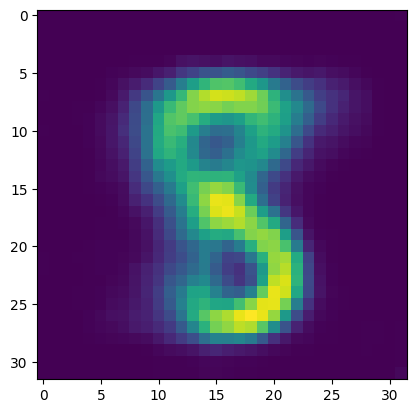

In [48]:
START = np.array([0.0, 0.5])
plt.imshow(latent_mapping(START).reshape(32, 32))

In [14]:
latent_path = create_latent_path(START, np.pi * 0.9, 10.0)
straight_path = create_straight_path(latent_path(0), latent_path(1), manifold_mnist)

In [23]:
start, end = latent_mapping(latent_path(0)), latent_mapping(latent_path(1))

np.sqrt((start - end) ** 2).sum()

93.97174

In [16]:
# plt.imshow(latent_mapping(latent_path(1)).reshape(32, 32))
#

In [49]:
draw_paths(BACKGROUND_TRACE, [latent_path, straight_path])

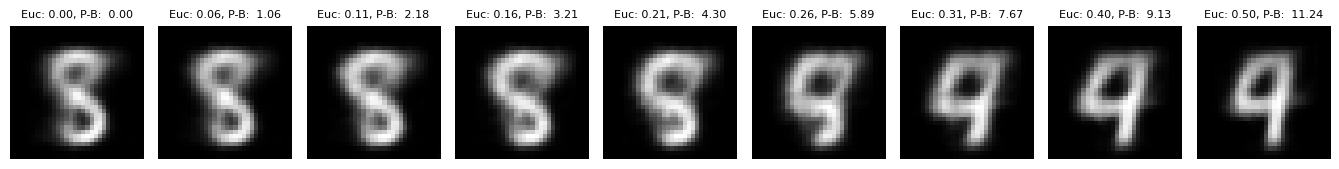

In [25]:
show_path_in_ambient(latent_path, 9)

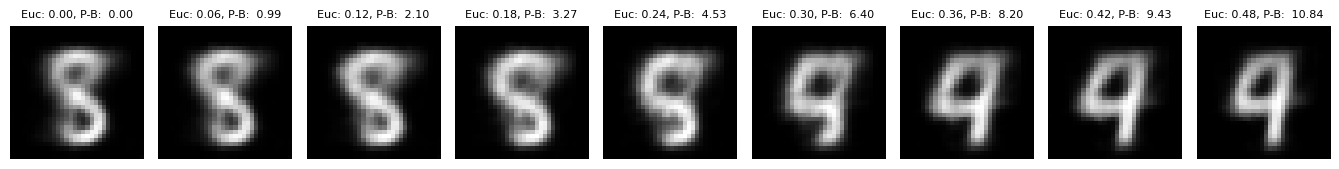

In [26]:
show_path_in_ambient(straight_path, 9)